In [2]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

#### When we look at any image, most of the time we identify a person using a face. An image might contain multiple faces, also the face can be obstructed and not clear. The first step in our pre-processing pipeline is to detect faces from an image. Once face is detected, we will detect eyes, if two eyes are detected then only we keep that image otherwise discard it.

In [150]:
img=cv2.imread(r'C:\Users\SIDDARTH\Desktop\Image_classification_project\test_images\serena1.jpg')
# img=cv2.imread(r'C:\Users\SIDDARTH\Desktop\Image_classification_project\Server\test_images\virat3.jpg')
img.shape

(1777, 2048, 3)

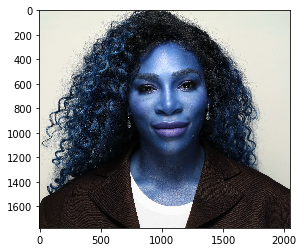

In [151]:
plt.imshow(img)

In [152]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml') # for detecting faces
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')  # for detecting eyes

AxesImage(54,36;334.8x217.44)


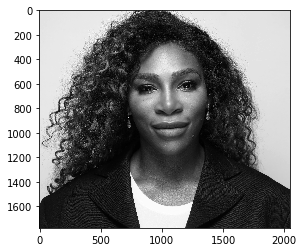

In [153]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(plt.imshow(gray,cmap='gray'))

In [157]:
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces  # it return x-axis y-axis width height

array([[679, 322, 751, 751]], dtype=int32)

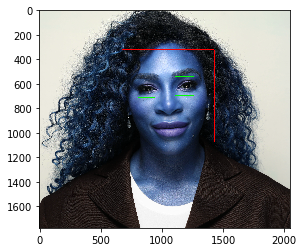

In [158]:
#### Now to detect eyes 
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)  # draw red rectangle around face
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)    
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2) # draw green rect around eyes
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

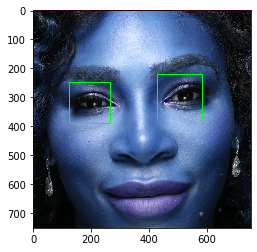

In [159]:
############## Now the pic needs to be cropped as we need only face, cropped image is roi_color
plt.imshow(roi_color)

######                 Main code to clean and crop input image dataset

In [61]:
## taking only those image in which face and 2 eyes are detected
def get_cropped_images(image_path):
    img=cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

In [54]:
image_dataset='../images_dataset/'
clean_croped_data='./clean_crop_dataset/'

In [42]:
import os
img_dirs = []
for entry in os.scandir(image_dataset):
    if entry.is_dir():
        img_dirs.append(entry.path)
img_dirs

['../images_dataset/lionel_messi',
 '../images_dataset/maria_sharapova',
 '../images_dataset/roger_federer',
 '../images_dataset/serena_williams',
 '../images_dataset/virat_kohli']

In [73]:
import shutil
if os.path.exists(clean_croped_dataset):
    shutil.remove(clean_croped_dataset)
os.mkdir(clean_croped_dataset)

In [74]:
cropped_image_dirs = []
# celebrity_file_names_dict = {}

for entry in img_dirs:
#     print(entry)
    count = 1
    f = entry.split('/')[-1]
    celebrity_file_names_dict[f]=[]
    for file in os.scandir(entry):
        ima = get_cropped_images(file.path)
        if ima is not None:
            crop_folder = clean_croped_data + f
            if not os.path.exists(crop_folder):
                os.mkdir(crop_folder)
                cropped_image_dirs.append(crop_folder)
                
            file_name_path = crop_folder + "/" + f + "_" + str(count) +'.png'  # path and of cropped file to save at
            count += 1
            cv2.imwrite(file_name_path, ima)
#             celebrity_file_names_dict[f].append(file_name_path)
            
            
            
        

In [75]:
cropped_image_dirs

['./clean_crop_dataset/lionel_messi',
 './clean_crop_dataset/maria_sharapova',
 './clean_crop_dataset/roger_federer',
 './clean_crop_dataset/serena_williams',
 './clean_crop_dataset/virat_kohli']

In [84]:
crop_image_path={}
for f in cropped_image_dirs:
    name = f.split('/')[-1]
    crop_image_path[name] = []
    for entry in os.scandir(f):
        crop_image_path[name].append(entry.path)
        

In [85]:
crop_image_path

{'lionel_messi': ['./clean_crop_dataset/lionel_messi\\lionel_messi_1.png',
  './clean_crop_dataset/lionel_messi\\lionel_messi_10.png',
  './clean_crop_dataset/lionel_messi\\lionel_messi_11.png',
  './clean_crop_dataset/lionel_messi\\lionel_messi_13.png',
  './clean_crop_dataset/lionel_messi\\lionel_messi_14.png',
  './clean_crop_dataset/lionel_messi\\lionel_messi_15.png',
  './clean_crop_dataset/lionel_messi\\lionel_messi_16.png',
  './clean_crop_dataset/lionel_messi\\lionel_messi_17.png',
  './clean_crop_dataset/lionel_messi\\lionel_messi_18.png',
  './clean_crop_dataset/lionel_messi\\lionel_messi_19.png',
  './clean_crop_dataset/lionel_messi\\lionel_messi_2.png',
  './clean_crop_dataset/lionel_messi\\lionel_messi_20.png',
  './clean_crop_dataset/lionel_messi\\lionel_messi_22.png',
  './clean_crop_dataset/lionel_messi\\lionel_messi_23.png',
  './clean_crop_dataset/lionel_messi\\lionel_messi_24.png',
  './clean_crop_dataset/lionel_messi\\lionel_messi_25.png',
  './clean_crop_dataset/li

In [86]:
######################################## ---------------------- ###########################################################

###  (3) Preprocessing: Use wavelet transform as a feature for traning our model

#### In wavelet transformed image, you can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips etc

#### Wavelet transform

In [90]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

[[229 229 229 ... 204 204 204]
 [229 229 229 ... 204 204 204]
 [229 229 214 ...  59 204 204]
 ...
 [ 23  23 204 ...  27 236 236]
 [ 23  23  23 ... 236 236 236]
 [ 23  23  23 ... 236 236 236]]


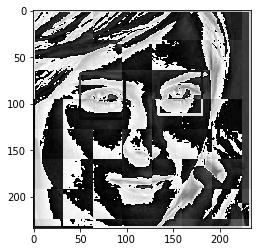

In [92]:
## You can see above a wavelet transformed image that gives clues on facial features such as eyes, nose, lips etc. 
## This along with raw pixel image can be used as an input for our classifier
im_har = w2d(roi_color,'db1',5)
# print(im_har)
plt.imshow(im_har, cmap='gray')

In [94]:
class_dict = {}
count = 0
for celebrity_name in crop_image_path.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

In [98]:
x=[]
y=[]
for i in crop_image_path:
    for j in crop_image_path[i]:
        img=cv2.imread(j)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        x.append(combined_img)
        y.append(class_dict[i])
        

In [99]:
len(x[0])

4096

In [100]:
32*32*3 + 32*32

4096

In [101]:
x = np.array(x).reshape(len(x),4096).astype(float)
x.shape

(160, 4096)

In [ ]:
####################### ---------------- Now we are ready for Model creation and training --------------- ################# 

In [105]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [103]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

In [108]:
# scaler=StandardScaler()
# x_train_transformed = scaler.fit_transform(x_train)


pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
print(pipe)
pipe.fit(x_train, y_train)
pipe.score(x_test, y_test)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=10, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)


0.825

In [ ]:
################### performing Grid-Search (Parameter tuning and model selection) ############################################

In [109]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [110]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [112]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(x_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.866667,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.666667,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.858333,{'logisticregression__C': 1}


In [113]:
best_estimators

{'svm': Pipeline(memory=None,
          steps=[('standardscaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('svc',
                  SVC(C=1, break_ties=False, cache_size=200, class_weight=None,
                      coef0=0.0, decision_function_shape='ovr', degree=3,
                      gamma='auto', kernel='linear', max_iter=-1,
                      probability=True, random_state=None, shrinking=True,
                      tol=0.001, verbose=False))],
          verbose=False),
 'random_forest': Pipeline(memory=None,
          steps=[('standardscaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('randomforestclassifier',
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gini',
                                         max_depth=None, max_features='auto',
                                   

In [ ]:
############################ ------------------- saving the model ------------------------------------------------------

In [114]:
best_clf = best_estimators['svm']
best_clf

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='linear', max_iter=-1,
                     probability=True, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [115]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_svm_model.pkl') 

['saved_svm_model.pkl']

In [ ]:
##################### ---------------- Predicting the test file --------------------------

In [116]:
best_clf

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='linear', max_iter=-1,
                     probability=True, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [120]:
def get_cropped_images_2(image):
    face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')
    img=cv2.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    cropped_faces = []
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            cropped_faces.append(roi_color)
    return cropped_faces

In [130]:
crop_img = get_cropped_images_2(r'C:\Users\SIDDARTH\Desktop\Image_classification_project\Server\test_images\virat3.jpg')
res = []
for imgg in crop_img:
    # img=cv2.imread(j)
    scalled_raw_img = cv2.resize(imgg, (32, 32))
    img_har = w2d(imgg,'db1',5)
    scalled_img_har = cv2.resize(img_har, (32, 32))
    combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
    len_image_array = 32*32*3 + 32*32

    final = combined_img.reshape(1,len_image_array).astype(float)
    res.append((best_clf.predict(final)[0],best_clf.predict_proba(final)[0][best_clf.predict(final)[0]]))
    #res.append(best_clf.predict_proba(final))
    
res    

[(4, 0.8097868612246188), (1, 0.39660814532996397)]